### MSCI 598 - Final Project
### Gaurav Mudbhatkal - 20747018

In [1]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical,plot_model

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate,Bidirectional

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [2]:
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from feature_engineering import clean, normalize_word, get_tokenized_lemmas, remove_stopwords
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission

from utils.system import parse_params, check_version

d = DataSet()

Reading dataset
Total stances: 49972
Total bodies: 1683


#### Data Processing

In [3]:
from tqdm import tqdm
def get_data(stances, dataset):
    h, b, y = [], [], []
    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
    X = []
    headlines = []
    bodies = []
    for i, (headline, body) in tqdm(enumerate(zip(h, b))):
        headlines.append(headline)
        bodies.append(body)
    df = pd.DataFrame(list(zip(headlines,bodies, y)), columns=['headlines','bodies','stances'])
    return df
fnc_df = get_data(d.stances,d)

49972it [00:00, 1668121.19it/s]


In [5]:
max_features = 5000
MAX_NB_WORDS = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 64

In [7]:
GLOVE_DIR = "glove_embeddings/"
def setup_embedding_index():
    embedding_index=dict()
    f = open(os.path.join(GLOVE_DIR,"glove.6B.50d.txt"),encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
    f.close()
    return embedding_index
embeddings_index = setup_embedding_index()

In [8]:
tokenizer_headline = Tokenizer(num_words=max_features, split=' ')
tokenizer_headline.fit_on_texts(fnc_df.loc[:,'headlines'].values)
vocab_headline_length = len(tokenizer_headline.word_index)+1

encoded_docs_headline = tokenizer_headline.texts_to_sequences(fnc_df.loc[:,'headlines'])
padded_docs_headline = pad_sequences(encoded_docs_headline, maxlen=16, padding='post')

print(vocab_headline_length)
word_index_headline = tokenizer_headline.word_index

NUM_WORDS_HEADLINE = vocab_headline_length

3880


In [9]:
tokenizer_body = Tokenizer(num_words=max_features, split=' ')
tokenizer_body.fit_on_texts(fnc_df.loc[:,'bodies'].values)
vocab_body_length = len(tokenizer_body.word_index)+1

encoded_docs_body = tokenizer_body.texts_to_sequences(fnc_df.loc[:,'bodies'])
padded_docs_body = pad_sequences(encoded_docs_body, maxlen=200, padding='post')

print(vocab_body_length)
word_index_body = tokenizer_body.word_index


NUM_WORDS_BODY = vocab_body_length
print(NUM_WORDS_BODY)

27428
27428


In [10]:
embedding_matrix_headline = np.zeros((NUM_WORDS_HEADLINE, EMBEDDING_DIM))

for word, i in tokenizer_headline.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_headline[i] = embedding_vector
dims = len(embedding_matrix_headline[0])

print(dims)

50


In [11]:
embedding_matrix_body = np.zeros((NUM_WORDS_BODY, EMBEDDING_DIM))

for word, i in tokenizer_body.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_body[i] = embedding_vector
dims = len(embedding_matrix_body[0])

print(dims)

50


In [12]:
print(padded_docs_headline.shape)
print(padded_docs_body.shape)

(49972, 16)
(49972, 200)


#### LSTM with separate embedding inputs

In [23]:
input_headline = Input(shape=16,name='input_headline')
embedding_layer_headline = Embedding(input_dim = vocab_headline_length,output_dim = 50,
                                     weights=[embedding_matrix_headline],
                                     input_length = 16,trainable=True)(input_headline)

input_body = Input(shape=200,name='input_body')
embedding_layer_body = Embedding(input_dim = vocab_body_length,output_dim = 50,weights = [embedding_matrix_body],
                                 input_length=200,trainable = True)(input_body)

addition_layer = concatenate([embedding_layer_headline,embedding_layer_body],axis=1)
lstm = LSTM(units=64,)(addition_layer)
drop = Dropout(0.25)(lstm)

output = Dense(4,activation='sigmoid')(drop)
model = Model(inputs=[input_headline,input_body],outputs=output)
model.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_headline (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 input_body (InputLayer)        [(None, 200)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 16, 50)       194000      ['input_headline[0][0]']         
                                                                                                  
 embedding_15 (Embedding)       (None, 200, 50)      1371400     ['input_body[0][0]']             
                                                                                            

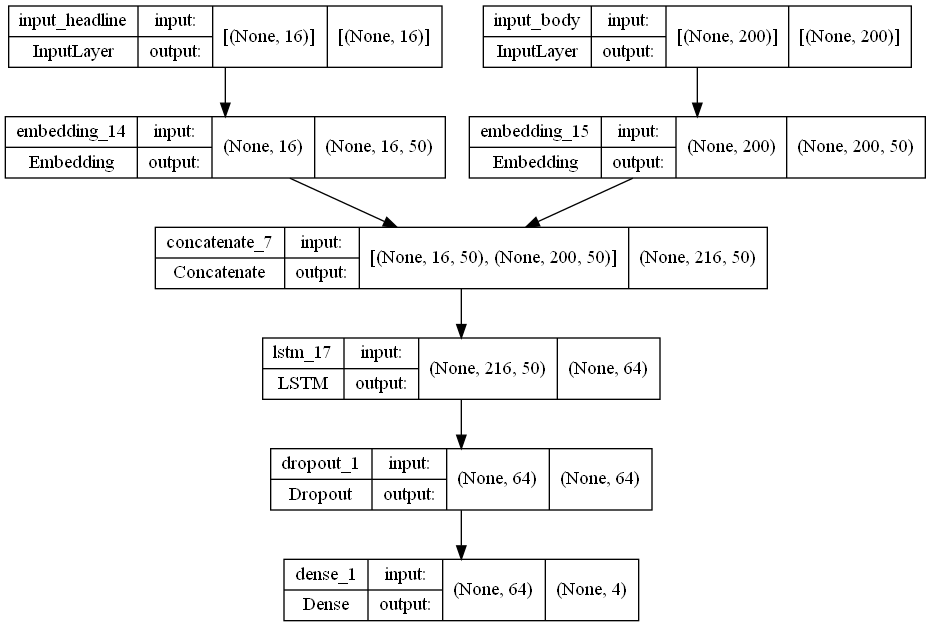

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_glove.png', show_shapes=True, show_layer_names=True)

In [27]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

from keras.utils.np_utils import to_categorical 
labels = to_categorical(fnc_df.loc[:,'stances'])

labels_train = labels[:int(len(labels)*0.9),:]
labels_test = labels[int(len(labels)*0.9):,:]

In [26]:
filepath = os.path.join(os.getcwd(),"{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [28]:
model_history = model.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=20,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test))

Epoch 1/20
1406/1406 [==============================] - 141s 99ms/step - loss: 0.7455 - accuracy: 0.7434 - val_loss: 0.6734 - val_accuracy: 0.7587
Epoch 2/20
1406/1406 [==============================] - 139s 99ms/step - loss: 0.6335 - accuracy: 0.7759 - val_loss: 0.6106 - val_accuracy: 0.7789
Epoch 3/20
1406/1406 [==============================] - 149s 106ms/step - loss: 0.5837 - accuracy: 0.7861 - val_loss: 0.5596 - val_accuracy: 0.7947
Epoch 4/20
1406/1406 [==============================] - 140s 100ms/step - loss: 0.5256 - accuracy: 0.8022 - val_loss: 0.5256 - val_accuracy: 0.8035
Epoch 5/20
1406/1406 [==============================] - 148s 105ms/step - loss: 0.4847 - accuracy: 0.8188 - val_loss: 0.5043 - val_accuracy: 0.8173
Epoch 6/20
1406/1406 [==============================] - 152s 108ms/step - loss: 0.4567 - accuracy: 0.8289 - val_loss: 0.4744 - val_accuracy: 0.8303
Epoch 7/20
1406/1406 [==============================] - 155s 110ms/step - loss: 0.4342 - accuracy: 0.8370 - val_lo

In [34]:
competition_dataset = DataSet("competition_test")

competition_df = get_data(competition_dataset.stances,competition_dataset)

## tokenizer
comp_headline_tokenizer = Tokenizer(num_words=max_features, split=' ')
comp_headline_tokenizer.fit_on_texts(competition_df.loc[:,'headlines'].values)
vocab_headline_length_comp = len(comp_headline_tokenizer.word_index)+1

encoded_docs_headline_comp = comp_headline_tokenizer.texts_to_sequences(competition_df.loc[:,'headlines'])
padded_docs_headline_comp = pad_sequences(encoded_docs_headline_comp, maxlen=16, padding='post')

print("Headline Vocab:")
print(vocab_headline_length_comp)
print("\n")
word_index_headline = comp_headline_tokenizer.word_index
NUM_WORDS_HEADLINE_COMP = vocab_headline_length_comp


comp_body_tokenizer = Tokenizer(num_words=max_features, split=' ')
comp_body_tokenizer.fit_on_texts(competition_df.loc[:,'bodies'].values)
vocab_body_length_comp = len(comp_body_tokenizer.word_index)+1

encoded_docs_body_comp = comp_body_tokenizer.texts_to_sequences(competition_df.loc[:,'bodies'])
padded_docs_body_comp = pad_sequences(encoded_docs_body_comp, maxlen=200, padding='post')

print("Body Vocab:")
print(vocab_body_length_comp)

word_index_body_comp = comp_body_tokenizer.word_index


NUM_WORDS_BODY_COMP = vocab_body_length_comp
print(NUM_WORDS_BODY)
print("\n")

labels_competition = to_categorical(competition_df.loc[:,'stances'])

Reading dataset
Total stances: 25413
Total bodies: 904


25413it [00:00, 1498690.24it/s]


Headline Vocab:
2623


Body Vocab:
19914
27428




In [35]:
# len(padded_docs_body_comp)
preds = model.predict([padded_docs_headline_comp, padded_docs_body_comp])

In [36]:
predicted = [LABELS[int(np.argmax(a))] for a in preds]
actual = [LABELS[int(np.argmax(a))] for a in labels_competition]
report_score(actual, predicted)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    363    |    10     |    309    |   1221    |
-------------------------------------------------------------
| disagree  |    114    |     1     |    123    |    459    |
-------------------------------------------------------------
|  discuss  |    860    |     8     |    725    |   2871    |
-------------------------------------------------------------
| unrelated |   3090    |    42     |   3286    |   11931   |
-------------------------------------------------------------
Score: 4427.75 out of 11651.25	(38.002360261774484%)


38.002360261774484

In [38]:
from sklearn.metrics import precision_score, recall_score
precision_score(actual,predicted, average='macro'), recall_score(actual,predicted, average='macro')

(0.24636222752152173, 0.2512056824862502)

In [ ]:
# results 
# lens = 16, 48
# loss: 0.0400 - accuracy: 0.9863 - val_loss: 0.2911 - val_accuracy: 0.9446
# -------------------------------------------------------------
# |           |   agree   | disagree  |  discuss  | unrelated |
# -------------------------------------------------------------
# |   agree   |    356    |     0     |    200    |   1347    |
# -------------------------------------------------------------
# | disagree  |    129    |     0     |    118    |    450    |
# -------------------------------------------------------------
# |  discuss  |    424    |     0     |    588    |   3452    |
# -------------------------------------------------------------
# | unrelated |   2542    |     0     |   2093    |   13714   |
# -------------------------------------------------------------
# Score: 4590.25 out of 11651.25	(39.3970604012445%)